In [1]:
import os
import cv2 as cv
import tensorflow as tf
from datetime import datetime
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import IPython.display as display
import PIL.Image
from math import ceil, floor
from datetime import datetime

time_str = datetime.now().strftime("%Y_%m_%d_%H_")
output_name = os.getcwd() + "/output_images/" + time_str

camera_file_dir = os.getcwd() + "/camera_exports/"
camera_file_paths = os.listdir(camera_file_dir)
camera_file_paths = [camera_file_dir + x for x in camera_file_paths if x.lower().endswith('.jpg') or x.lower().endswith('.png')]

global img_num
img_num = 0
print(output_name)

source_img_paths = camera_file_paths
print("{} source image paths : ".format(len(source_img_paths)), [x[-20:] for x in source_img_paths])

width = 640 * 2
height = 480 * 2

# create a basic naming root for any files that we create and want to save during this session
time_str = datetime.now().strftime("%Y_%m_%d_%H_")
output_name = os.getcwd() + "/camera_exports/" + time_str
img_num = 0
print(output_name)

# list all possible devices that the camera might be
# create a video capture device
vid_cap = cv.VideoCapture(0)
fourcc = cv.VideoWriter_fourcc(*'MJPG')
vid_out = cv.VideoWriter('webcam_out_{}.mp4'.format(img_num), fourcc, 20.0, (width, height))
if not vid_cap.isOpened():
    print("ERROR opening video capture object")

camera_greyscale = False

# simple function to load image
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

# simple function to display image
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

def save_images(images):
    global img_num
    for i in range(len(images)):
        tf.keras.utils.save_img(output_name + str(img_num) + ".png", images[i])
        img_num = img_num + 1

def save_image(image):
    global img_num
    tf.keras.utils.save_img(output_name + str(img_num) + ".png", np.squeeze(image, 0))
    img_num = img_num + 1

def plot_images(images):
    print("images length: ", len(images))
    if len(images) > 1:
        nrows, hop_size = adjustGrid(len(images))
        plt.figure(figsize=(hop_size*10, nrows*10))
        plt.margins(0.0)
        # for each lines of the plo%
        print("plotting {} total images with {} columns in {} rows".format(len(images), hop_size, nrows))
        for i in range(len(images)):
            ax = plt.subplot(nrows, hop_size, i+1)
            plt.imshow(images[i])
            plt.axis("off")
            plt.savefig(output_name + str(img_num) + "_figure.png")
    else:
      plot_image(image)

def plot_image(image):
    image = np.squeeze(image, 0)
    plt.figure(figsize=(20, 20))
    plt.margins(0.0)
    plt.imshow(image)
    plt.axis("off")
    plt.savefig(output_name + str(img_num) + "_figure.png")

def singleImage(source, style):
    output_images = []
    source_image = load_img(source)
    style_image = load_img(style)
    output_images.extend(hub_model(tf.constant(source_image), tf.constant(style_image))[0])
    save_images(output_images)
    output_images.extend(style_image)
    output_images.extend(source_image)
    output_images.reverse()
    plot_images(output_images)

def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)


def adjustGrid(num, cmax=5):
    # find place where we "flip", use that to determine number of rows and columns
    # go from 1 to half of number
    rnum = 1
    cnum = num
    for rn in range(1, ceil(num/2) +1):
        rnum = rn
        cnum = ceil(num/rnum)
        # if the number of columns is no longer greater than the number of rows, undo the change and export numbers
        if cnum <= rnum and cnum <= cmax:
            break
    total = rnum * cnum
    # if total < num:
    # rnum = rnum + 1
    return (rnum, cnum)

# Download an image and read it into a NumPy array.
def loadImage(path, max_dim=None):
  img = PIL.Image.open(path)
  if max_dim:
    img.thumbnail((max_dim, max_dim))
  return np.array(img)

# Normalize an image
def deprocess(img):
  img = 255*(img + 1.0)/2.0
  return tf.cast(img, tf.uint8)

# Display an image
def show(img):
  display.display(PIL.Image.fromarray(np.array(img)))

def readCamera():
    # function to capture images from webcam and present them using imshow
    ret, frame = vid_cap.read()
    # if frame is read correctly ret is True
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        return None
    # Our operations on the frame come here
    if camera_greyscale is True:
        frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

    return frame

def displayImage(img):
    # Display the resulting frame
    cv.imshow('frame', img)
    # if cv.waitKey(1) == ord('q'):
    # # break

def save_images(images):
    global img_num
    for i in range(len(images)):
        tf.keras.utils.save_img(output_name + str(img_num) + ".png", images[i])
        img_num = img_num + 1

def save_image(image):
    global img_num
    cv.imwrite(output_name + str(img_num) + ".png", image)
    img_num = img_num + 1

def plot_images(images):
    print("images length: ", len(images))
    if len(images) > 1:
        nrows, hop_size = adjustGrid(len(images))
        plt.figure(figsize=(hop_size*10, nrows*10))
        plt.margins(0.0)
        # for each lines of the plo%
        print("plotting {} total images with {} columns in {} rows".format(len(images), hop_size, nrows))
        for i in range(len(images)):
            ax = plt.subplot(nrows, hop_size, i+1)
            plt.imshow(images[i])
            plt.axis("off")
            plt.savefig(output_name + str(img_num) + "_figure.png")
    else:
      plot_image(image)

def plot_image(image):
    plt.figure(figsize=(20, 20))
    plt.margins(0.0)
    plt.imshow(image)
    plt.axis("off")
    plt.savefig(output_name + str(img_num) + "_figure.png")

    # simple function to display image
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

2023-02-20 12:58:45.332469: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


/Users/nathan/workspace/tensor_flow_projects/neural_art_bots/output_images/2023_02_20_12_
2 source image paths :  ['2_20_12_1_figure.png', '/2023_02_20_12_0.png']
/Users/nathan/workspace/tensor_flow_projects/neural_art_bots/camera_exports/2023_02_20_12_


OpenCV: FFMPEG: tag 0x47504a4d/'MJPG' is not supported with codec id 7 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


## Deep Dreaming Functions

In [2]:
# Deep Dreaming Functions
def calc_loss(img, model):
  # Pass forward the image through the model to retrieve the activations.
  # Converts the image into a batch of size 1.
  img_batch = tf.expand_dims(img, axis=0)
  layer_activations = model(img_batch)
  if len(layer_activations) == 1:
    layer_activations = [layer_activations]

  losses = []
  for act in layer_activations:
    loss = tf.math.reduce_mean(act)
    losses.append(loss)

  return  tf.reduce_sum(losses)

class DeepDream(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.float32),)
  )
  def __call__(self, img, steps, step_size):
      print("Tracing")
      loss = tf.constant(0.0)
      for n in tf.range(steps):
        with tf.GradientTape() as tape:
          # This needs gradients relative to `img`
          # `GradientTape` only watches `tf.Variable`s by default
          tape.watch(img)
          loss = calc_loss(img, self.model)

        # Calculate the gradient of the loss with respect to the pixels of the input image.
        gradients = tape.gradient(loss, img)

        # Normalize the gradients.
        gradients /= tf.math.reduce_std(gradients) + 1e-8 
        
        # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
        # You can update the image by directly adding the gradients (because they're the same shape!)
        img = img + gradients*step_size
        img = tf.clip_by_value(img, -1, 1)

      return loss, img

# great, now lets setup a deepdream model
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
# Maximize the activations of these layers
names = ['mixed3', 'mixed5']
layers = [base_model.get_layer(name).output for name in names]
# Create the feature extraction model
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)
dream_imgs = []

deepdream = DeepDream(dream_model)

def run_deep_dream_simple(img, steps=100, step_size=0.01):
  # Convert from uint8 to the range expected by the model.
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  img = tf.convert_to_tensor(img)
  step_size = tf.convert_to_tensor(step_size)
  steps_remaining = steps
  step = 0
  while steps_remaining:
    if steps_remaining>100:
      run_steps = tf.constant(100)
    else:
      run_steps = tf.constant(steps_remaining)
    steps_remaining -= run_steps
    step += run_steps

    loss, img = deepdream(img, run_steps, tf.constant(step_size))
    print ("Step {}, loss {}".format(step, loss))
    
  result = deprocess(img)
  return result

2023-02-20 12:58:52.037089: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


(720, 1280, 3)


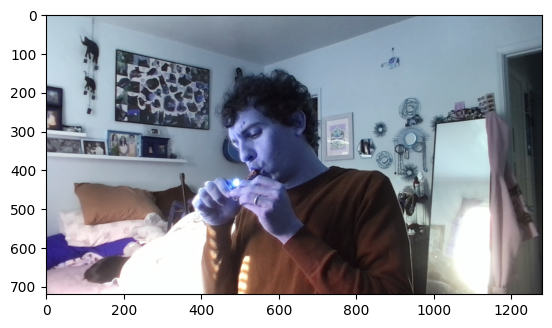

In [3]:
image = readCamera()
print(image.shape)
imshow(image)
save_image(image)

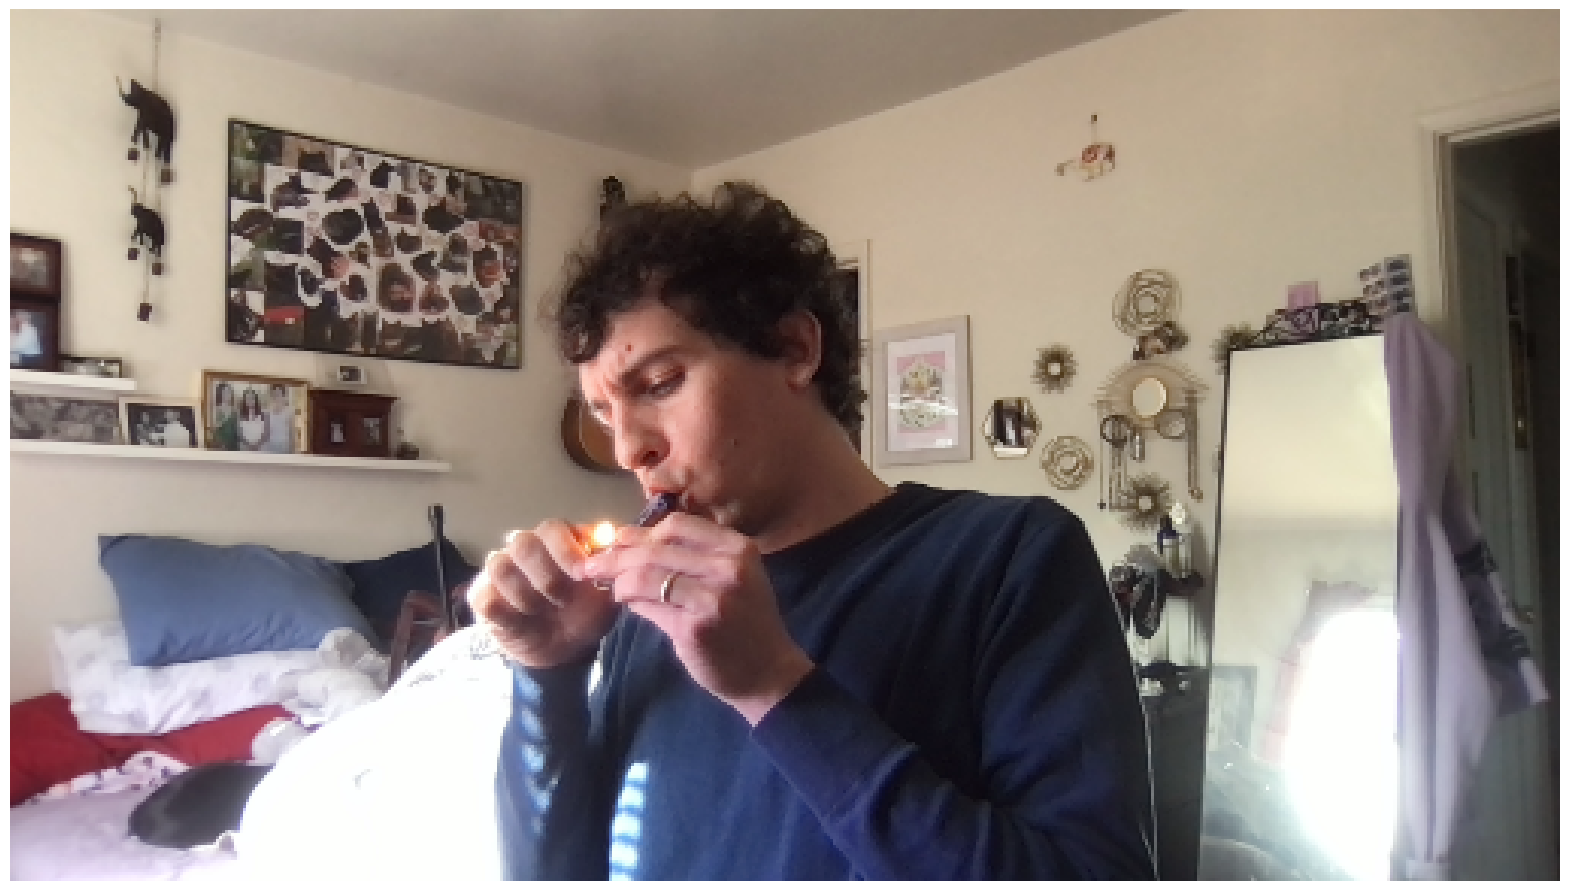

In [4]:
camera_file_paths = os.listdir(camera_file_dir)
camera_file_paths = [camera_file_dir + x for x in camera_file_paths if x.lower().endswith('.jpg') or x.lower().endswith('.png')]
img_path = camera_file_paths[-1]
# Downsizing the image makes it easier to work with.
original_img = load_img(img_path)[0]
plot_image(original_img)

<class 'tensorflow.python.framework.ops.EagerTensor'> (288, 512, 3)
Tracing
Step 50, loss 1.728644847869873


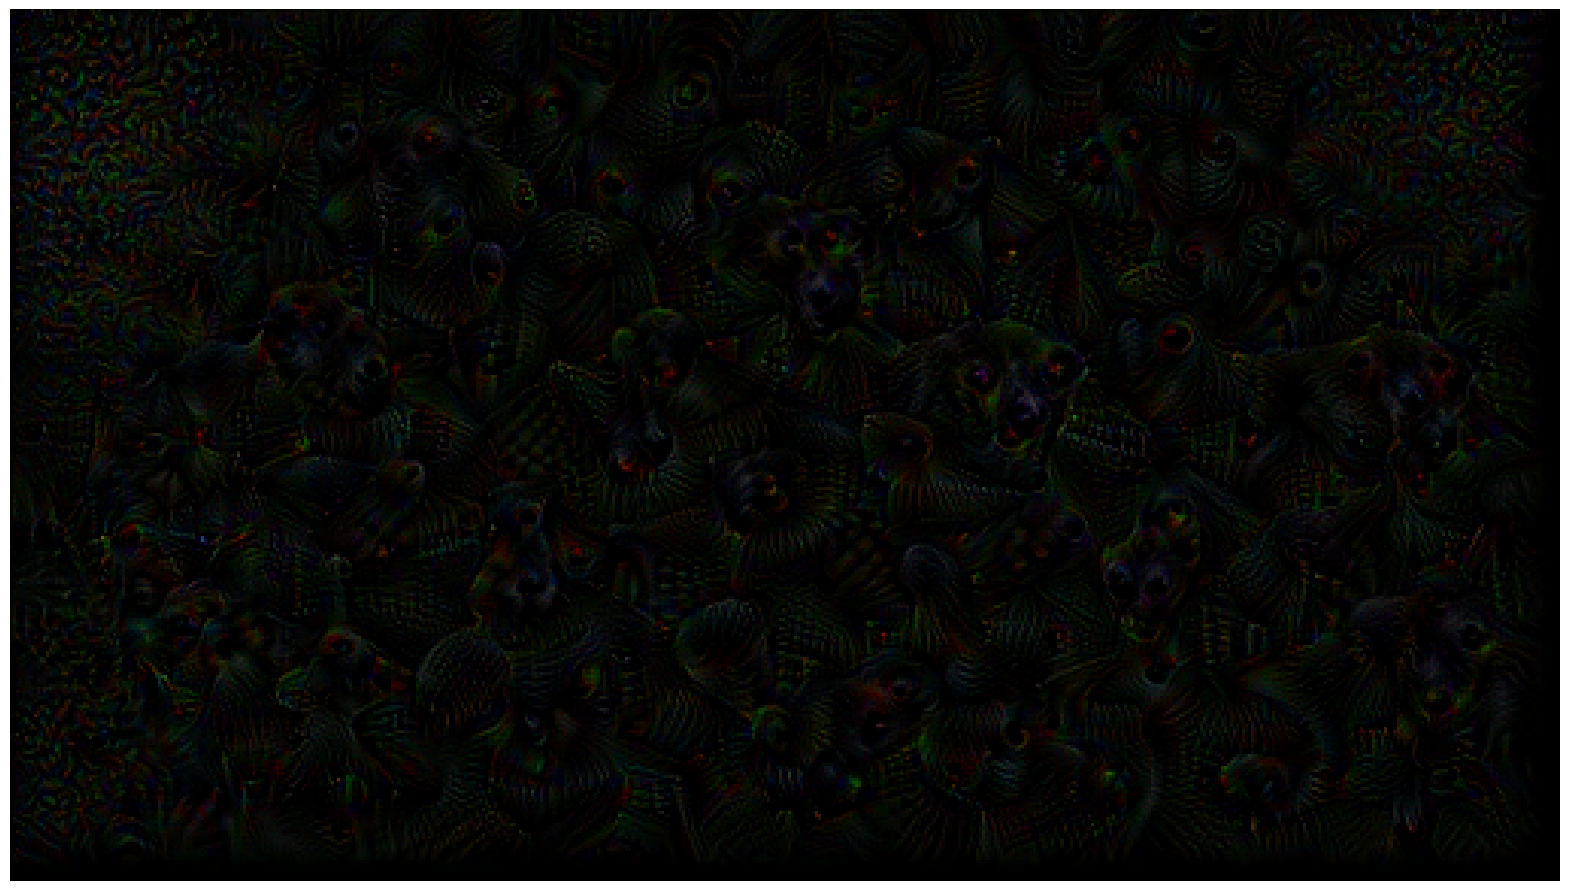

In [5]:
print(type(original_img), original_img.shape)
# and run the function on our image
dream_output_img = run_deep_dream_simple(img=original_img, 
                                  steps=50, step_size=0.01)
plot_image(dream_output_img)

In [6]:
# hmm, cool, now lets try to  produce a better dream image
class TiledGradients(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[2], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.int32),)
  )
  def __call__(self, img, img_size, tile_size=512):
    shift, img_rolled = random_roll(img, tile_size)

    # Initialize the image gradients to zero.
    gradients = tf.zeros_like(img_rolled)
    
    # Skip the last tile, unless there's only one tile.
    xs = tf.range(0, img_size[1], tile_size)[:-1]
    if not tf.cast(len(xs), bool):
      xs = tf.constant([0])
    ys = tf.range(0, img_size[0], tile_size)[:-1]
    if not tf.cast(len(ys), bool):
      ys = tf.constant([0])
 
    for x in xs:
      for y in ys:
        # Calculate the gradients for this tile.
        with tf.GradientTape() as tape:
          # This needs gradients relative to `img_rolled`.
          # `GradientTape` only watches `tf.Variable`s by default.
          tape.watch(img_rolled)

          # Extract a tile out of the image.
          img_tile = img_rolled[y:y+tile_size, x:x+tile_size]
          loss = calc_loss(img_tile, self.model)

        # Update the image gradients for this tile.
        gradients = gradients + tape.gradient(loss, img_rolled)

    # Undo the random shift applied to the image and its gradients.
    gradients = tf.roll(gradients, shift=-shift, axis=[0,1])

    # Normalize the gradients.
    gradients /= tf.math.reduce_std(gradients) + 1e-8 

    return gradients
  
get_tiled_gradients = TiledGradients(dream_model)

def run_deep_dream_with_octaves(img, steps_per_octave=100, step_size=0.01, 
                                octaves=range(-2,3), octave_scale=1.3):
  base_shape = tf.shape(img)
  img = tf.keras.utils.img_to_array(img)
  img = tf.keras.applications.inception_v3.preprocess_input(img)

  initial_shape = img.shape[:-1]
  img = tf.image.resize(img, initial_shape)
  for octave in octaves:
    # Scale the image based on the octave
    new_size = tf.cast(tf.convert_to_tensor(base_shape[:-1]), tf.float32)*(octave_scale**octave)
    new_size = tf.cast(new_size, tf.int32)
    img = tf.image.resize(img, new_size)

    for step in range(steps_per_octave):
      gradients = get_tiled_gradients(img, new_size)
      img = img + gradients*step_size
      img = tf.clip_by_value(img, -1, 1)

      if step % 10 == 0:
        display.clear_output(wait=True)
        show(deprocess(img))
        print ("Octave {}, Step {}".format(octave, step))
    
  result = deprocess(img)
  return result

In [10]:
print(type(original_img), original_img.shape)
octave_outputs = []
octave_outputs.append(run_deep_dream_with_octaves(img=original_img, step_size=0.01))
# img = tf.image.resize(img, base_shape)
# img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
plot_image(octave_output)

<class 'tensorflow.python.framework.ops.EagerTensor'> (288, 512, 3)


ValueError: output array is read-only

In [ ]:
# vid_cap.release()
# vid_out.release()
# cv.destroyAllWindows()